# Data assimilation

In this task, we are exploring whether it has a gained value to assimilate the precipitation field computed by NWP and radar extrapolations by using Kalman Filter.

Methodologies pls refer to [A reduced space Kalman filter](https://journals.ametsoc.org/mwr/article/147/3/987/107474/A-Reduced-Space-Ensemble-Kalman-Filter-Approach)

In [38]:
import filterpy
import numpy
import matplotlib.pyplot as plt
from osgeo import gdal
from numpy.random import randn
from filterpy.kalman import EnsembleKalmanFilter as EnKF
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import rasterio
import rasterio.mask
import fiona
import os

In [39]:
shp_pth= '/home/allen/Documents/Projects/Harvey/excessive_rain/subbasins/08076700.shp'
with fiona.open(shp_pth, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
QPE_dir='/home/allen/Documents/Projects/Ensemble_Nowcast/MRMS/20170826'
QPF_dir='/home/allen/Documents/Projects/Ensemble_Nowcast/extrapolation/20170826_adapt'

In [40]:
delta= pd.Timedelta('6M')
dr= pd.date_range('20170826120000', '20170826145400', freq='0.1H')

QPEs=[]
QPFs=[[]]
for hour in dr:
    print(hour)
    fname= hour.strftime('PrecipRate_00.00_%Y%m%d-%H%M%S.grib2-var0-z0.tif')
    QPE_pth= os.path.join(QPE_dir, fname)
    with rasterio.open(QPE_pth) as src:
        QPE, _ = rasterio.mask.mask(src, shapes, crop=True)
        QPEs.append(QPE)
    for mem in range(10):
        QPF_pth= os.path.join(QPF_dir, '2017082612', fname[:-4]+'_mem%02d.tif'%mem)
        with rasterio.open(QPF_pth) as src:
            _QPF=rasterio.mask.mask(src, shapes, crop=True)[0]
        _QPF[_QPF<0]= np.nan
        _QPF[_QPF>200]= np.nan
        QPFs[-1].append(_QPF)
    QPFs.append([])
del QPFs[-1]
QPFs= np.stack(QPFs)
QPEs= np.stack(QPEs)

2017-08-26 12:00:00


/home/allen/Documents/Programs/miniconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater


2017-08-26 12:06:00
2017-08-26 12:12:00
2017-08-26 12:18:00
2017-08-26 12:24:00
2017-08-26 12:30:00
2017-08-26 12:36:00
2017-08-26 12:42:00
2017-08-26 12:48:00
2017-08-26 12:54:00
2017-08-26 13:00:00
2017-08-26 13:06:00
2017-08-26 13:12:00
2017-08-26 13:18:00
2017-08-26 13:24:00
2017-08-26 13:30:00
2017-08-26 13:36:00
2017-08-26 13:42:00
2017-08-26 13:48:00
2017-08-26 13:54:00
2017-08-26 14:00:00


/home/allen/Documents/Programs/miniconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less


2017-08-26 14:06:00
2017-08-26 14:12:00
2017-08-26 14:18:00
2017-08-26 14:24:00
2017-08-26 14:30:00
2017-08-26 14:36:00
2017-08-26 14:42:00
2017-08-26 14:48:00
2017-08-26 14:54:00


In [42]:
#read in HRRR
#hrrr.t12z.wrfsfcf00.grib2.rainrate_warp.tif
HRRRs= []
for i, hour in enumerate(pd.date_range('20170826120000', '20170826145400', freq='1H')):
    HRRR_fname= '/home/allen/Documents/Projects/Ensemble_Nowcast/HRRR/hrrr.t12z.wrfsfcf%02d.grib2.rainrate_warp.tif'%(i)

    with rasterio.open(HRRR_fname) as src:
        HRRR, _ = rasterio.mask.mask(src, shapes, crop=True)
        HRRR*= 3600
        HRRRs.append(HRRR)
HRRRs=np.stack(HRRRs)

In [44]:
QPFs.shape

(30, 10, 1, 149, 283)

In [45]:
def hx(x):
    return np.array([x[0]])

def fx(x, dt):
    '''Update function, here we use extrapolated function'''
    return x[int(dt)+1]

# x = X[:,0,320,400]
QPFs= np.nanmean(np.nanmean(QPFs,axis=3),axis=3).squeeze()
P = np.eye(10) * 100.
enf = EnKF(x=x, P=P, dim_z=1, dt=1., N=10, hx=hx, fx=fx)
std_noise = 10.
enf.R *= std_noise**2
# enf.Q = Q_discrete_white_noise(2, 1., .001)

/home/allen/Documents/Programs/miniconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


In [46]:
HRRRs.shape

(3, 1, 150, 283)

In [47]:
zs=[]
results= []
measurements= []
ps= []
for t in range(30-1):
    if t%10==0:
        z= np.nanmean(np.nanmean(HRRRs, axis=2), axis=2).squeeze()[t//10]
#         z= Zs[t//10,320,640] + std_noise
    zs.append(z)
    enf.predict()
    enf.update(np.asarray([z]))
    results.append (enf.x[0])
    measurements.append(z)
    ps.append(3*(enf.P[0,0]**.5))    

In [49]:
QPEs.shape

(30, 1, 149, 283)

In [50]:
true= np.nanmean(np.nanmean(QPEs,axis=2),axis=2).squeeze()

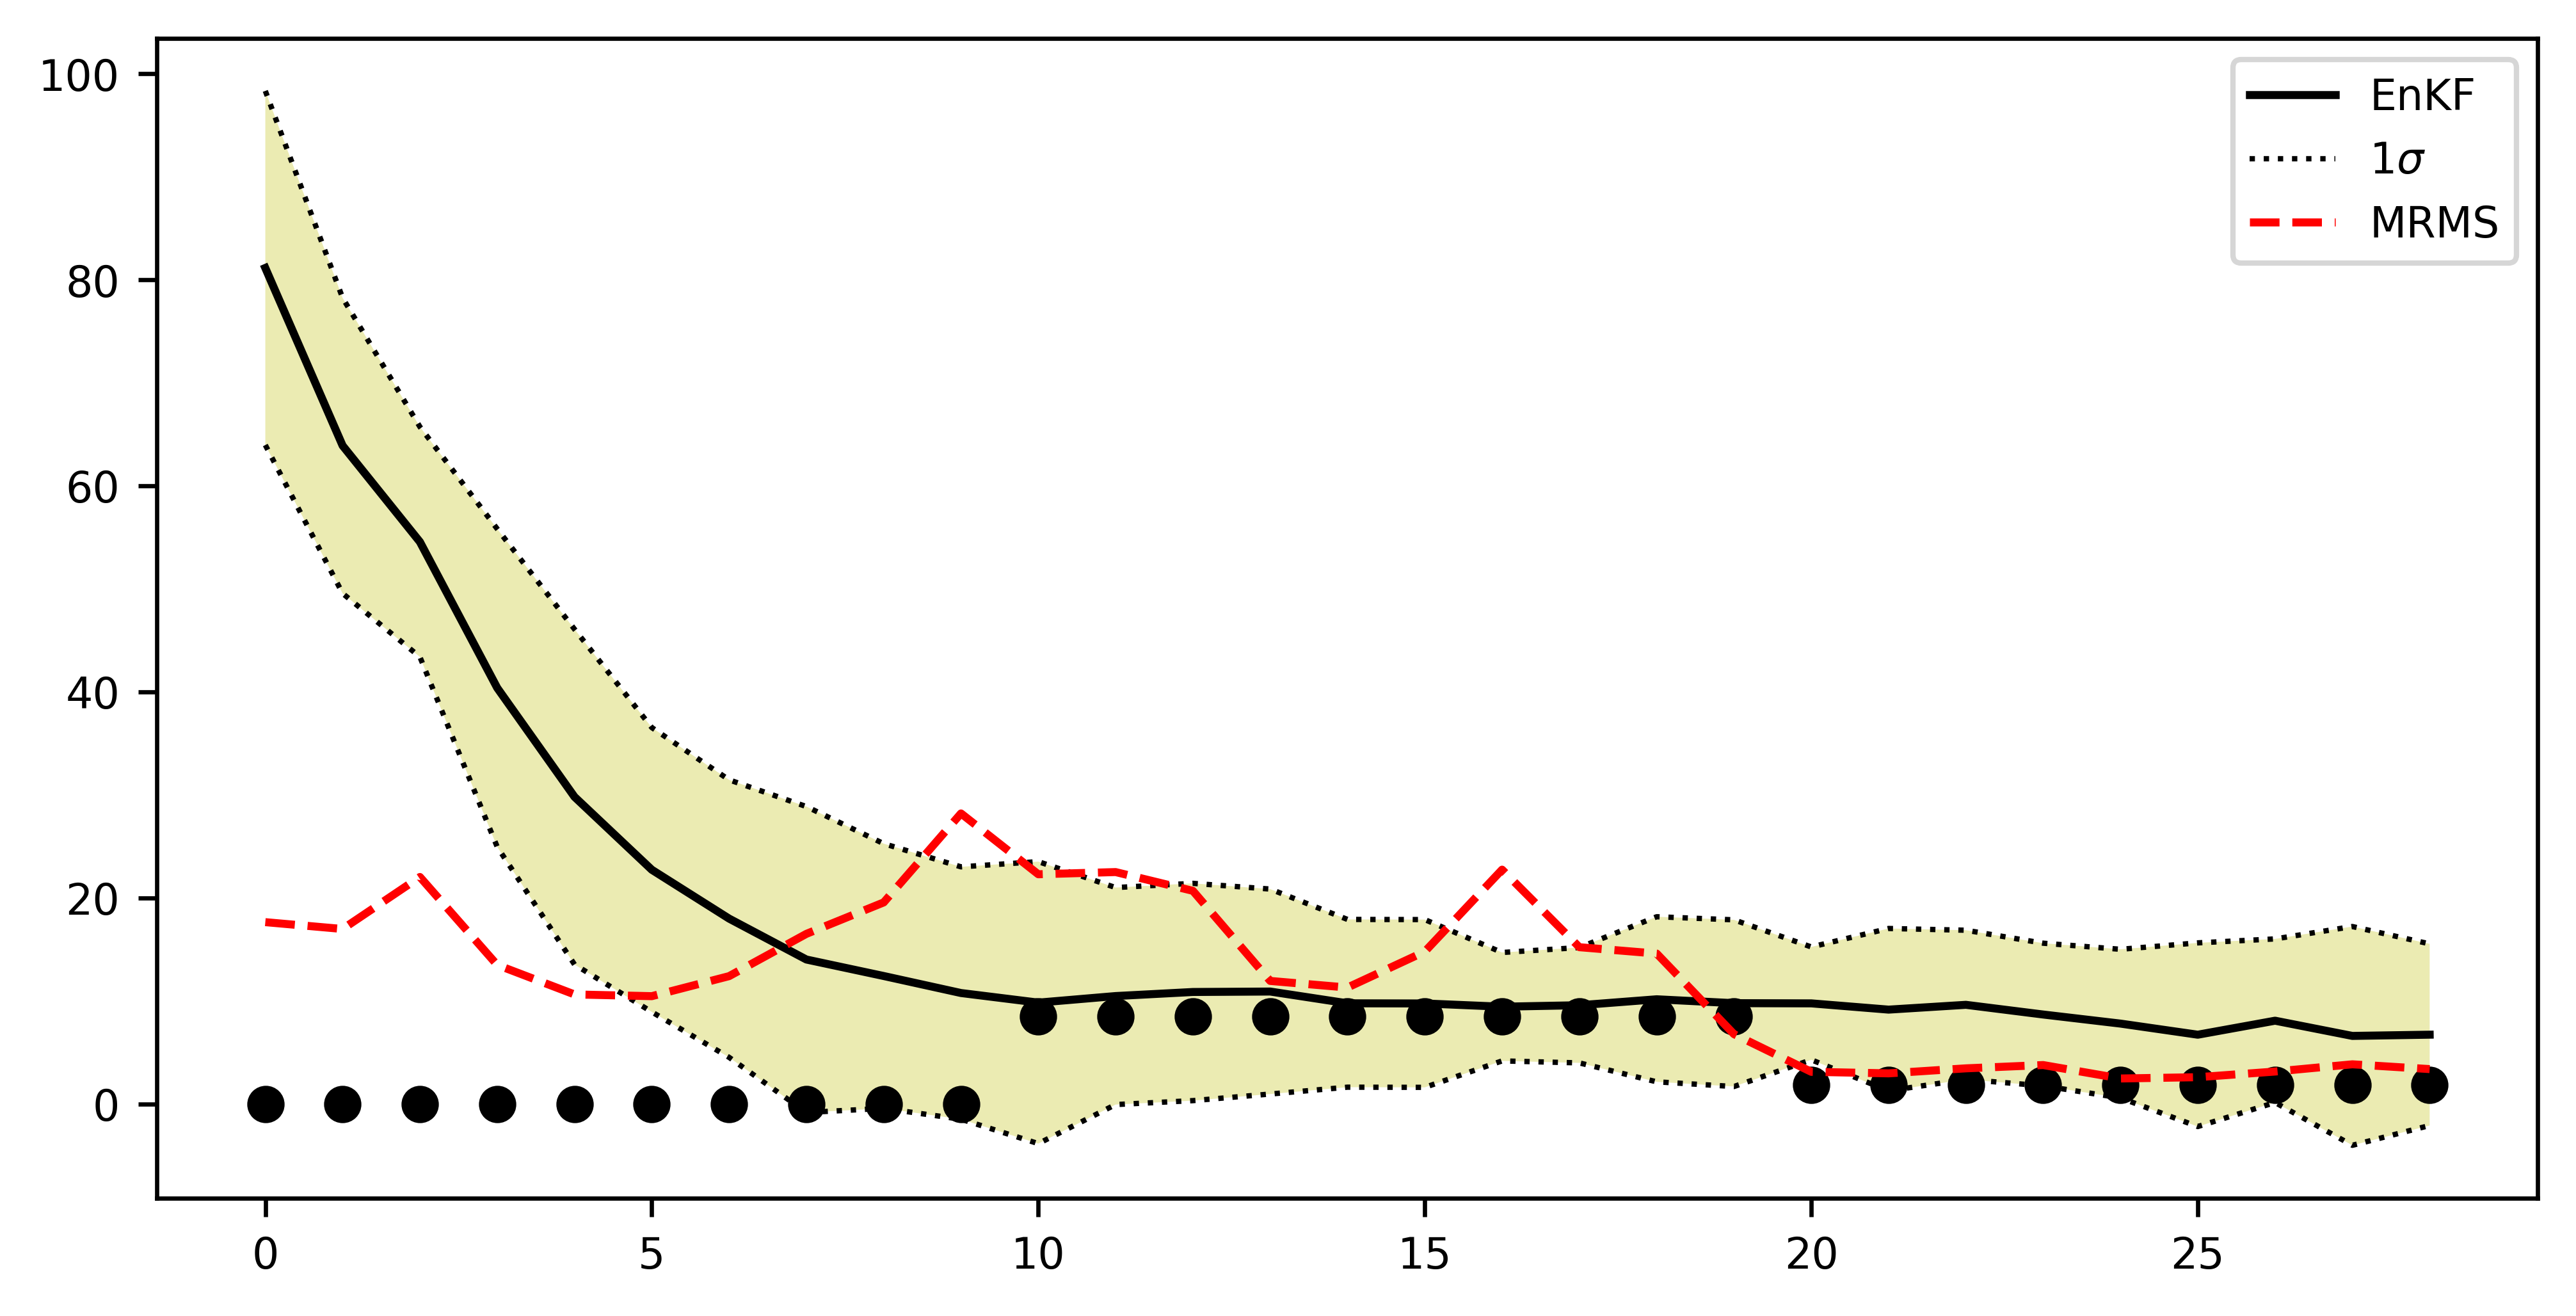

In [53]:
results = np.asarray(results)
ps = np.asarray(ps)
fig= plt.figure(figsize=(8,4))
plt.plot(results, label='EnKF')
plt.plot(measurements,'ko')
plt.plot (results - ps, c='k',linestyle=':', lw=1, label='1$\sigma$')
plt.plot(results + ps, c='k', linestyle=':', lw=1)
plt.fill_between(range(29), results - ps, results + ps, facecolor='y', alpha=.3)
plt.plot(range(29), true[1:], label='MRMS')
plt.plot()
plt.legend(loc='best');